### **Libraries**

In [3]:
# Library imports
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pennylane as qml
import h5py

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from python_package.metrics import FID
from IPython.display import clear_output
from itertools import product
from python_package.qg_test import ModelTest



# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# **Model specs**

In [4]:
test = ModelTest(
    test_id = '11',
    num_qubits = 7,
    num_aux_qubits = 2,
    circuit_depth = 10,
    num_generators = 2,
    rotations = ['Y'],
    generator_lr = 0.004,
    discriminator_lr = 0.01,
    batch_size = 1,
    num_samples = 512,
    num_epochs = 30,
    y = 0.3,
    channel = 'ECAL',
    optimizer= 'SGD',
    resolution= '8x8'
)

test.display_specs()

Data saved in /home/reyguadarrama/GSoC/src/python_package/../../tests/ECAL_tests/log/11_specs.json



# qGAN Individual Test Specification

## General Information
- **Test ID**: 11
- **Date**: 2024-07-21

### **Training dataset features**
| Parameter            | Value  |
|----------------------|--------|
| Resolution     | 8x8   |
| Interpolation  | Sumpool   |
| Channel        | ECAL      |
| Transformation | None      |

### **Quantum Circuit Parameters**
| Parameter            | Value  |
|----------------------|--------|
| Number of Qubits     | 7      |
| Number of Auxiliary Qubits | 2      |
| Circuit Depth        | 10      |
| Rotations per layer  | ['Y']   |
| output transf denominator | 0.3        |

### **GAN Parameters**
| Parameter            | Value  |
|----------------------|--------|
| Number of Generators | 2      |
| Generator Learning Rate  | 0.004 |
| Discriminator Learning Rate  | 0.01 |
| Batch Size           | 1     |
| Number of Samples    | 512   |
| Number of epochs     | 30 |
| Optimizer            | SGD  |

## Hardware and Software
- **Hardware used**: CPU AMD Ryzen 5 5600G
- **Framework**: Pytorch and Pennylane


# **Sum pooled jets**

In [5]:
with h5py.File("/home/reyguadarrama/GSoC/data/gluon_data/gluon_ECAL_sumpool_8x8.h5", 'r') as file:
    all_gluon_8x8 = file['gluon_ECAL_sumpool_8x8'][:test.num_samples]

In [6]:
gluon_ECAL_overlay = np.mean(all_gluon_8x8, axis=0)
total_energy = np.sum(all_gluon_8x8, axis=(1,2))
particles_energy_deposits = all_gluon_8x8[all_gluon_8x8 > 0]

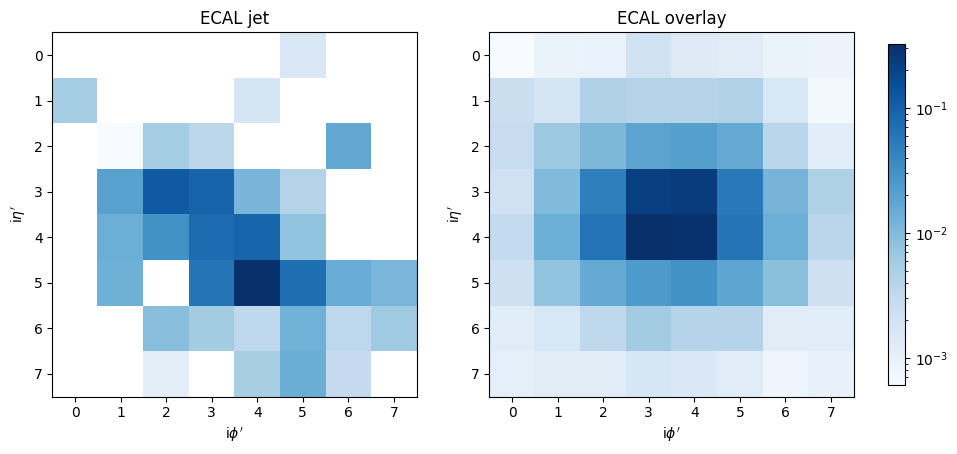

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

im1 = axs[0].imshow(all_gluon_8x8[0], cmap="Blues", norm=mcolors.LogNorm())
axs[0].set_title("ECAL jet")

axs[1].imshow(gluon_ECAL_overlay, cmap="Blues", norm=mcolors.LogNorm())
axs[1].set_title("ECAL overlay")

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()

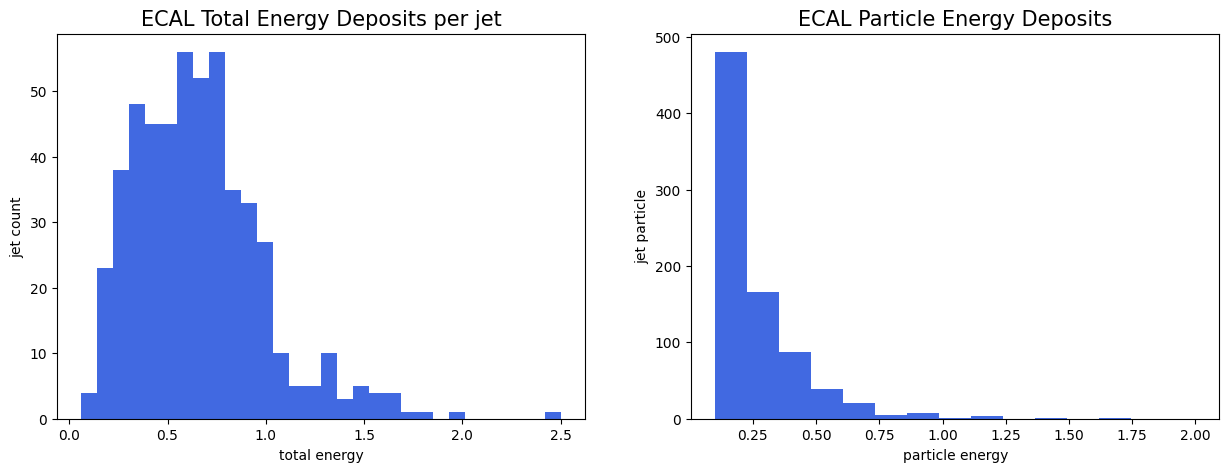

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(total_energy, bins=30, color="royalblue")
axs[0].set_title("ECAL Total Energy Deposits per jet", fontsize=15)
axs[0].set_xlabel("total energy")
axs[0].set_ylabel("jet count")

axs[1].hist(particles_energy_deposits, range=(0.1, 2), bins=15, color="royalblue")
axs[1].set_title("ECAL Particle Energy Deposits", fontsize=15)
axs[1].set_xlabel("particle energy")
axs[1].set_ylabel("jet particle")

plt.show()

# **Training**

In [9]:
class QuarkDataset(Dataset):
    def __init__(self, image):
        self.data = torch.tensor(image, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
# Create the data loader instance
dataset = QuarkDataset(all_gluon_8x8.reshape(test.num_samples, 64))
dataloader = DataLoader(dataset, batch_size=test.batch_size, shuffle=True)

In [11]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(64, 128),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(128, 32),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [12]:
dev = qml.device("default.qubit", wires=test.num_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="backprop")
def quantum_circuit(noise, weights, rotations):
    weights = weights.reshape(test.circuit_depth, test.num_qubits, len(rotations))

    # Initialise latent vectors
    for i in range(test.num_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(test.circuit_depth):
         # Parameterised layer
        for q in range(test.num_qubits):
            for idx, rotation in enumerate(rotations):
                if rotation == "X":
                    qml.RX(weights[i][q][idx], wires=q)
                elif rotation == "Y":
                    qml.RY(weights[i][q][idx], wires=q)
                elif rotation == "Z":
                    qml.RZ(weights[i][q][idx], wires=q)

        # Control Z gates
        for y in range(test.num_qubits - 1):
            qml.CZ(wires=[y, y + 1])
        qml.CZ(wires=[test.num_qubits - 1, 0])

    return qml.probs(wires=list(range(test.num_qubits)))

In [13]:
weights = torch.rand(test.num_qubits*test.circuit_depth*len(test.rotations))
noise = torch.rand(8, test.num_qubits, device=device) * np.pi / 2

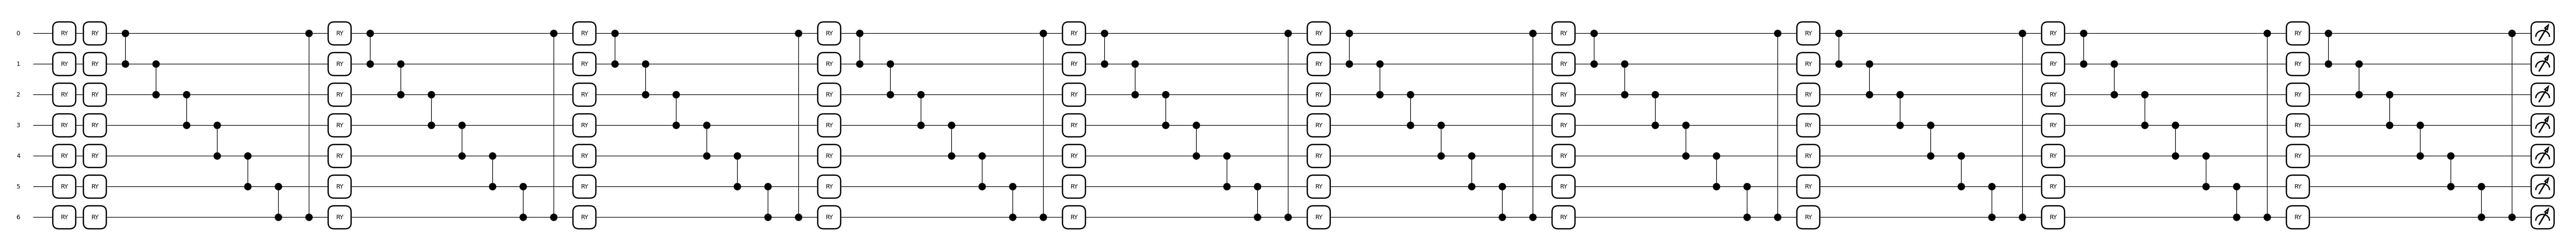

In [14]:
qml.draw_mpl(quantum_circuit)(noise, weights, test.rotations)
plt.show()

In [15]:
def partial_measure(noise, weights, rotations):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights, rotations)
    probsgiven0 = probs[: (2 ** (test.num_qubits - test.num_aux_qubits))]

    # Post-Processing
    probsgiven = probsgiven0 / test.y
    probsgiven[probsgiven < 0.001] = 0
    return probsgiven

In [16]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()


        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(test.num_qubits*test.circuit_depth*len(test.rotations)), requires_grad=True)
                for _ in range(n_generators)
            ]
        )

        self.n_generators = n_generators

    def forward(self, x, rotations):
        # Size of each sub-generator output
        patch_size = 2 ** (test.num_qubits - test.num_aux_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params, rotations).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)
            


        return images 

In [17]:
def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(rms_error) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

    # Metric 1
    ax1.set_title("RMSE", fontsize=15)
    ax1.plot(epochs, rms_error, color="royalblue", linewidth=3)
    ax1.set_xlabel("Epoch")
    ax1.set_yscale("log")
    ax1.grid()

    # Metric 2
    ax2.set_title("FID", fontsize=15)
    ax2.plot(epochs, fid, color="cornflowerblue", linewidth=3)
    ax2.set_xlabel("Epoch")
    ax2.set_yscale("log")
    ax2.grid()

    # Generated distribution
    im = ax3.imshow(gen_ECAL_overlay, cmap='Blues', aspect='auto', norm=mcolors.LogNorm())
    ax3.set_title('Generated ECAL overlay', fontsize=15)

    fig.colorbar(im, ax=ax3)

    plt.suptitle(f"Epoch {counter}", fontsize=25)
    plt.show()

In [18]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(test.num_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimizers
optD = optim.SGD(discriminator.parameters(), lr=test.discriminator_lr)
optG = optim.SGD(generator.parameters(), lr=test.generator_lr)

real_labels = torch.full((test.batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((test.batch_size,), 0.0, dtype=torch.float, device=device)

# Iteration counter
counter = 0

# plot lists
rms_error = []
fid = []
epochs = []
disc_loss = []
gen_loss = []


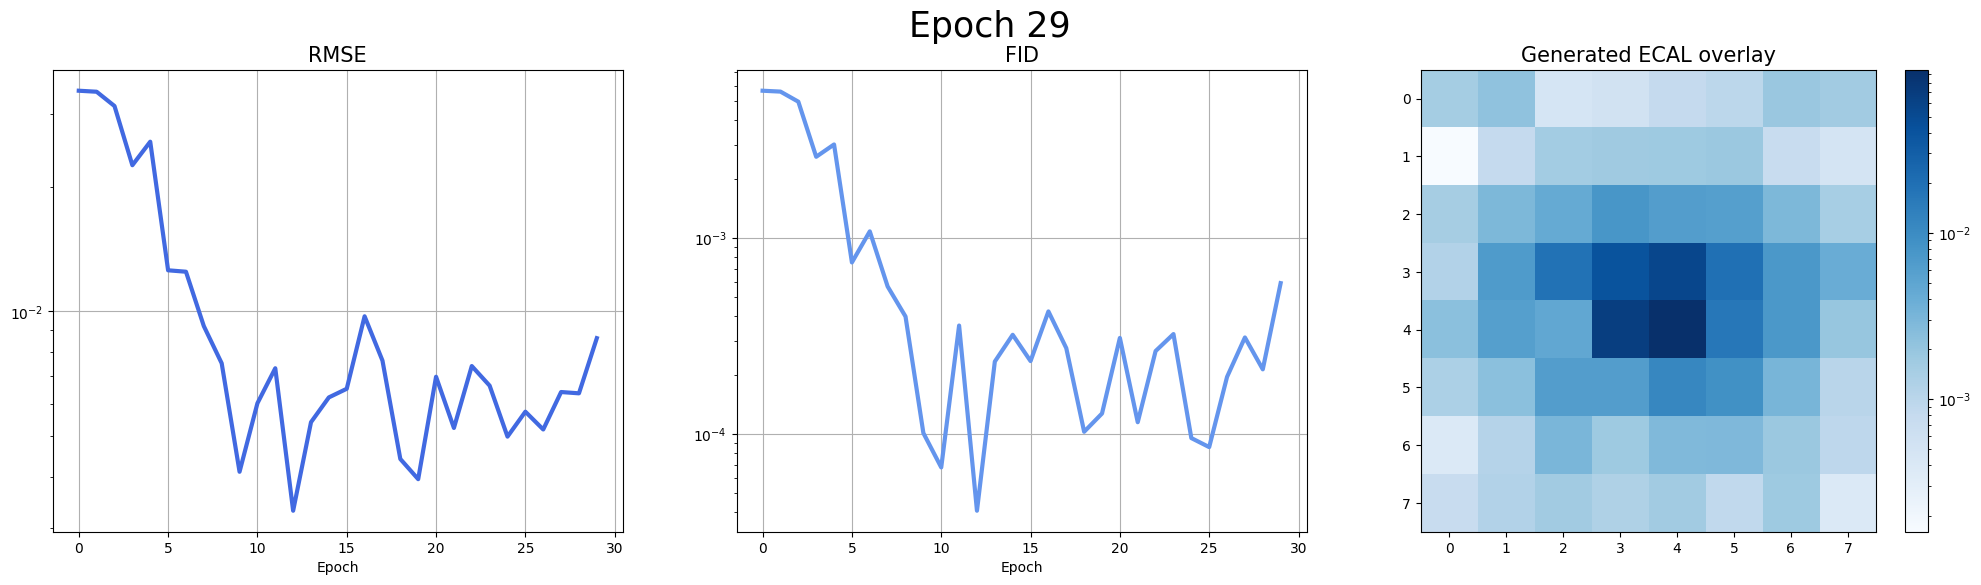

In [19]:
while counter < test.num_epochs:

    noise = torch.rand(test.num_samples, test.num_qubits, device=device)* np.pi / 2
    gen_ECAL_overlay = np.mean(generator(noise, test.rotations).detach().numpy().reshape(test.num_samples, 8, 8), axis=0)
    fd = FID(gluon_ECAL_overlay, gen_ECAL_overlay)
    rms = np.sqrt(np.mean((gluon_ECAL_overlay - gen_ECAL_overlay) ** 2))
    fid.append(fd)
    rms_error.append(rms)
    epochs.append(counter)

    plot_training_progress()
    
    for i, data in enumerate(dataloader):


        # Data for training the discriminator
        #data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(test.batch_size, test.num_qubits, device=device) * np.pi / 2
        fake_data = generator(noise, test.rotations)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()
            
    counter += 1
    disc_loss.append(errD)
    gen_loss.append(errG)
    

# **Results**

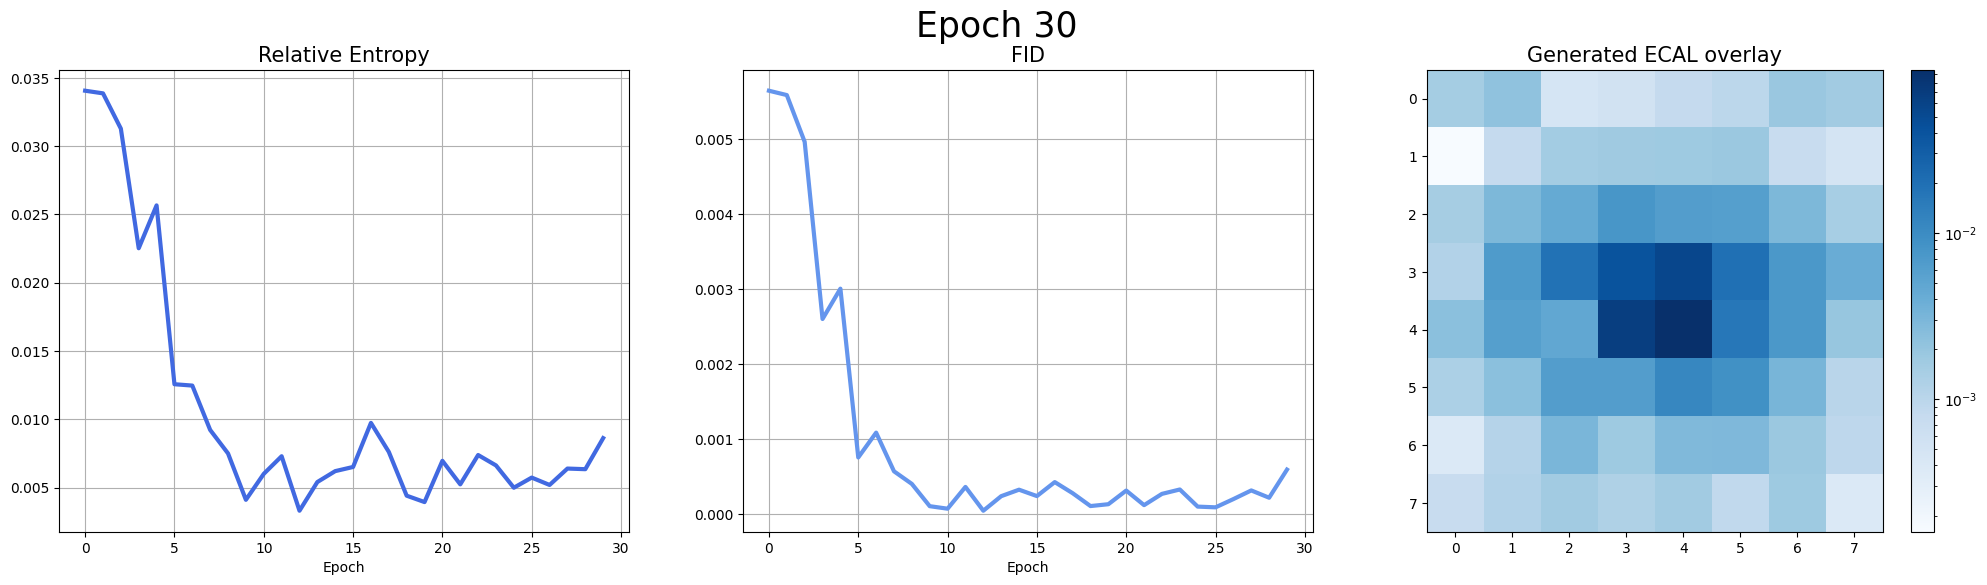

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

# Metric 1
ax1.set_title("Relative Entropy", fontsize=15)
ax1.plot(epochs, rms_error, color="royalblue", linewidth=3)
ax1.set_xlabel("Epoch")
#ax1.set_yscale("log")
ax1.grid()

# Metric 2
ax2.set_title("FID", fontsize=15)
ax2.plot(epochs, fid, color="cornflowerblue", linewidth=3)
ax2.set_xlabel("Epoch")
#ax2.set_yscale("log")
ax2.grid()

# Generated distribution
im = ax3.imshow(gen_ECAL_overlay, cmap='Blues', aspect='auto', norm=mcolors.LogNorm())
ax3.set_title('Generated ECAL overlay', fontsize=15)

fig.colorbar(im, ax=ax3)

plt.suptitle(f"Epoch {counter}", fontsize=25)
plt.show()

In [21]:
generated_jets = generator(torch.rand(test.num_samples, test.num_qubits, device=device) * np.pi / 2, test.rotations).detach().numpy().reshape(test.num_samples, 8, 8)


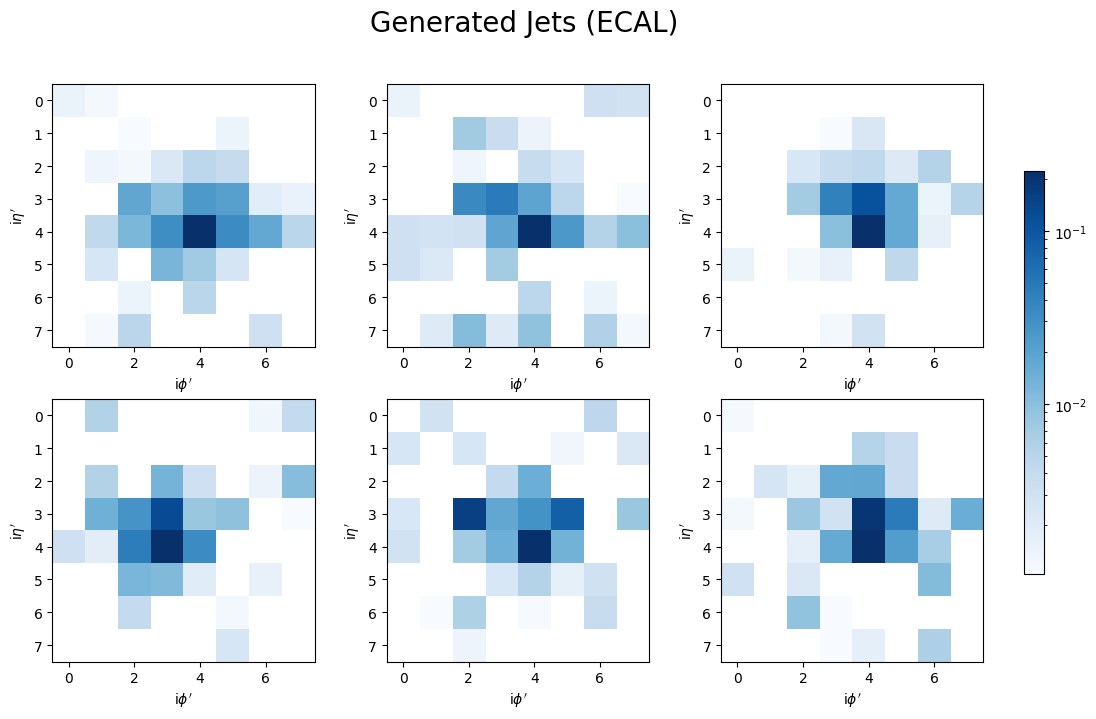

In [22]:

fig, axs = plt.subplots(2, 3, figsize=(13, 7.5)) 

for i, j in product(range(2), range(3)):
    jet = np.random.randint(0, 300)
    im1 = axs[i, j].imshow(generated_jets[jet], cmap="Blues", norm=mcolors.LogNorm())
    axs[i, j].set_xlabel("Energy Deposits")
    axs[i, j].set_ylabel("jet count")

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.suptitle(f"Generated Jets (ECAL)", fontsize=20)
plt.show()

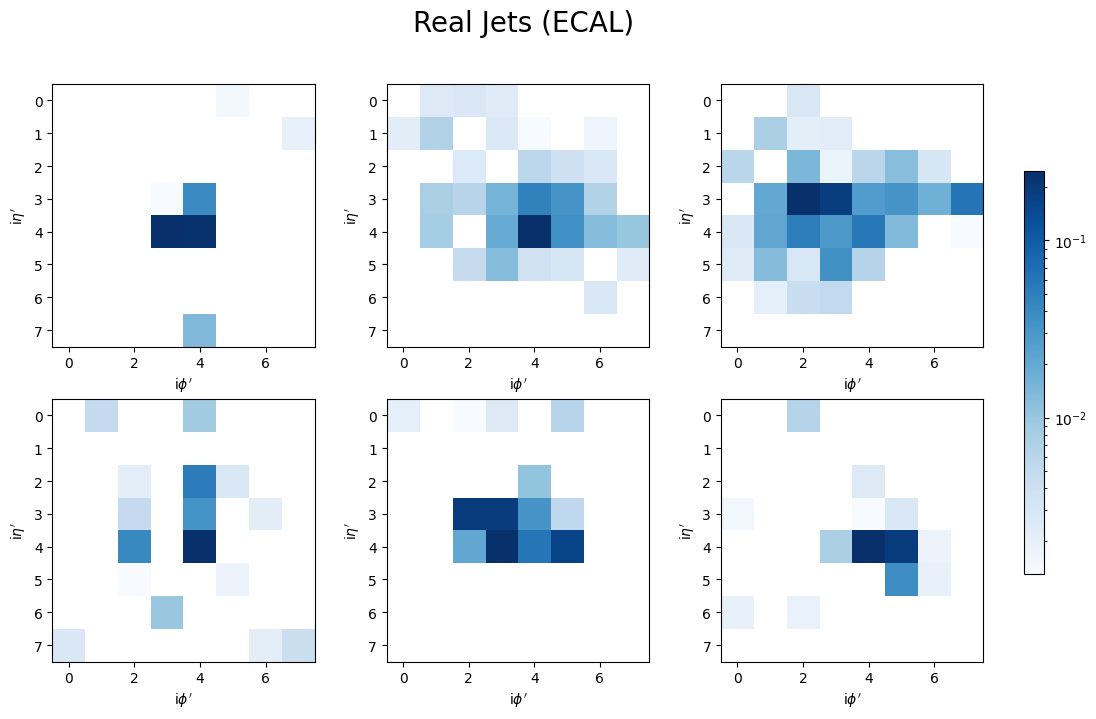

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(13, 7.5)) 

for i, j in product(range(2), range(3)):
    jet = np.random.randint(0, 300)
    im1 = axs[i, j].imshow(all_gluon_8x8[jet], cmap="Blues", norm=mcolors.LogNorm())
    axs[i, j].set_xlabel("Energy Deposits")
    axs[i, j].set_ylabel("jet count")

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.suptitle(f"Real Jets (ECAL)", fontsize=20)
plt.show()

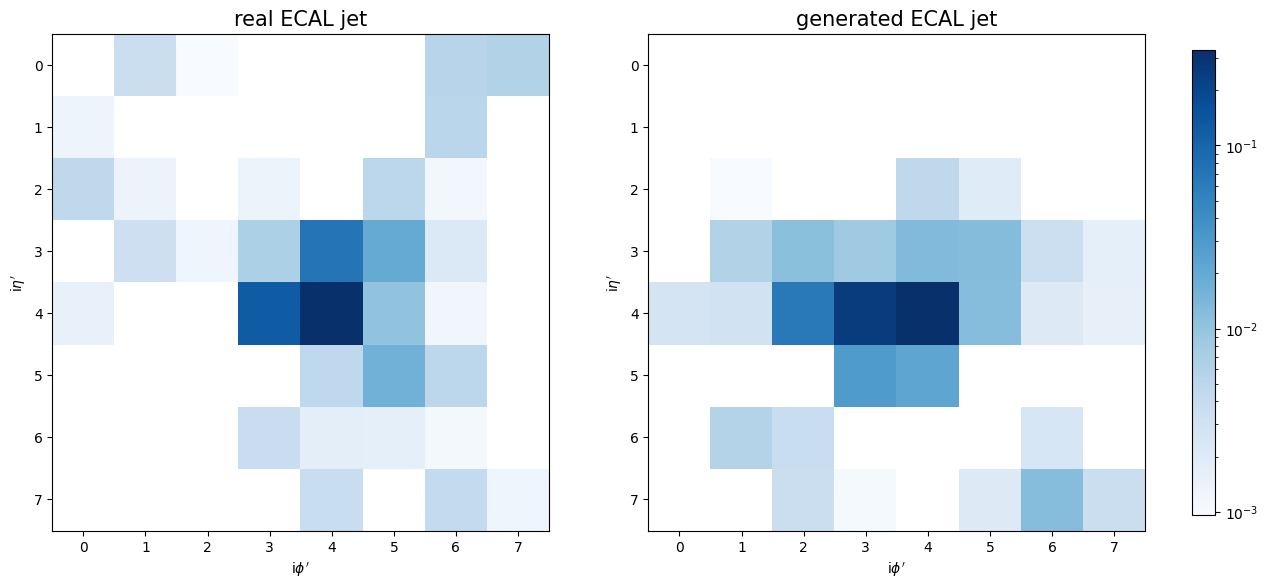

In [24]:
fig, axs =  plt.subplots(1, 2, figsize=(15, 7)) 
n = np.random.randint(0, 500)

im1 = axs[0].imshow(all_gluon_8x8[n], cmap="Blues", norm=mcolors.LogNorm())
axs[0].set_title("real ECAL jet", fontsize=15)

im2 = axs[1].imshow(generated_jets[n], cmap='Blues', norm=mcolors.LogNorm())
axs[1].set_title("generated ECAL jet", fontsize=15)

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

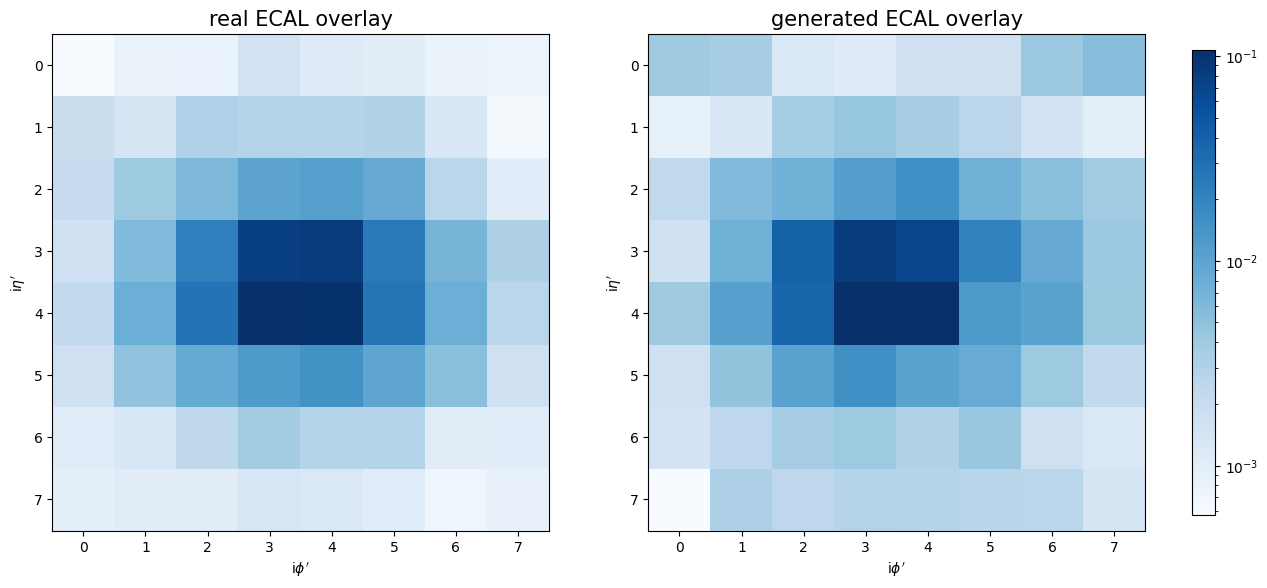

In [25]:
gen_jets_image = np.mean(generated_jets, axis=0)
real_jets_image = np.mean(all_gluon_8x8, axis=0)

fig, axs =  plt.subplots(1, 2, figsize=(15, 7)) 

im1 = axs[0].imshow(real_jets_image, cmap="Blues", norm=mcolors.LogNorm())
axs[0].set_title("real ECAL overlay", fontsize=15)

im2 = axs[1].imshow(gen_jets_image, cmap='Blues', norm=mcolors.LogNorm())
axs[1].set_title("generated ECAL overlay", fontsize=15)

for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

In [26]:
gen_total_energy = np.sum(generated_jets, axis=(1,2))


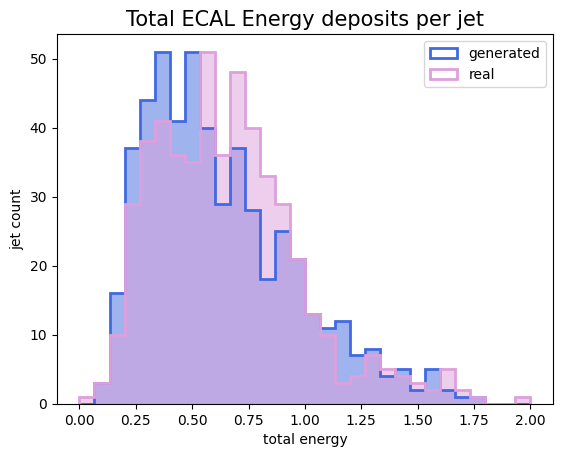

In [27]:
plt.hist(gen_total_energy, range=(0, 2), bins=30, color="royalblue", label="generated", histtype="step", linewidth=2)
plt.hist(gen_total_energy, range=(0, 2), bins=30, color="royalblue", alpha=0.5)
plt.hist(total_energy, range=(0, 2), bins=30, color="plum", label="real", histtype="step", linewidth=2)
plt.hist(total_energy, range=(0, 2), bins=30, color="plum", alpha=0.5)
plt.title("Total ECAL Energy deposits per jet", fontsize=15)
plt.xlabel("total energy")
plt.ylabel("jet count")
plt.legend()
plt.show()

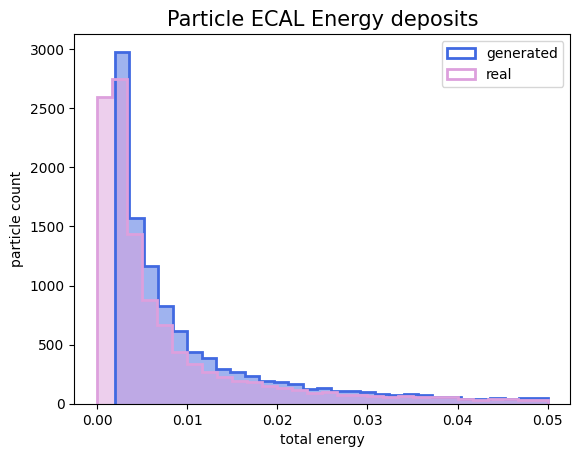

In [28]:
gen_particles_energy_deposits = generated_jets[generated_jets > 0]

plt.hist(gen_particles_energy_deposits, range=(0.002, 0.05), bins=30, color="royalblue", label="generated", histtype="step", linewidth=2)
plt.hist(gen_particles_energy_deposits, range=(0.002, 0.05), bins=30, color="royalblue", alpha=0.5)
plt.hist(particles_energy_deposits, range=(0, 0.05), bins=30, color="plum", label="real", histtype="step", linewidth=2)
plt.hist(particles_energy_deposits, range=(0, 0.05), bins=30, color="plum", alpha=0.5)
plt.title("Particle ECAL Energy deposits", fontsize=15)
plt.xlabel("total energy")
plt.ylabel("particle count")
plt.legend()
plt.show()

# **Save Results**

In [30]:
metrics = {
    'FID': "{:.2e}".format(fid[-1]),
    'RMSE': "{:.2e}".format(rms_error[-1]),
    'discriminator loss': "{:.2e}".format(disc_loss[-1]),
    'generator loss': "{:.2e}".format(gen_loss[-1]),
    'notes': "analysis pending"
}

test.save_results_to_json(metrics=metrics)
test.save_trained_params(generator=generator)

Data saved in /home/reyguadarrama/GSoC/src/python_package/../../tests/ECAL_tests/log/11_specs.json
Trained parameters saved in /home/reyguadarrama/GSoC/src/python_package/../../tests/ECAL_tests/log/../trained_params/test-11_generator_params.h5


In [31]:
%run summary.py

The README.md has been updated with the results table.
